# Nowcasting using Seasonal Autoregressive Integrated Moving Average Implementation 

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

## Nowcasting 

Now casting is a technique in which the probability of occurrence of large magnitude earthquakes is found by computing the cumulative distribution of small earthquakes that occur between large magnitude earthquakes. To compute this cumulative distribution, the number of small earthquakes are tabulated to find the probability distribution function and subsequently cumulative distribution function is found. Once, we have this cumulative distribution, we can use it to find, what is the probability that large earthquake will occur next.

## Importing libraries and settings

In [24]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, date
import math
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from matplotlib import pyplot
from tqdm import tqdm
from matplotlib import pyplot
RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

## Function to get dataset

Data is obtained from United States Geological Survey [1], the latitude range for the earthquake occurences is 20°S and 40°S and longitude range is 70°E to 105°E
<img src="./dataset.png">

In [25]:
def get_dataset():
    data = pd.read_csv("./query_large.csv", sep=",")
    np_date = ["" for i in range(len(data))]
    
    data = data[296:]
    data = data.iloc[::-1]
    # use data after 1973, because before 1973 only above 5 mag earthquake were recorded
   
    for i,item in enumerate(data["time"]):
        np_date[i] = datetime.strptime(item[:-5], '%Y-%m-%dT%H:%M:%S')
    
    X = np.array(data["mag"])
    
    
    #find first occurence of magnitude 5 earthquake
    for i in range(len(X)):
        if X[i] >= 5:
            X = X[i:]
            break
    
    count = 1
    
    ans = []
    
    new_data = []
    for i in range(len(X)):
        if X[i] < 5:
            #print('in if ' + str( X[i]))
            count = count + 1
        else:
           # print('in else ' + str( X[i]))
           # print('appended '+ str(count))
            ans.append(count)
            count = 0
            #new_data.append(data["time"][i])
    data_f = pd.DataFrame(data = ans, columns = ['timeSinceLast'])
    return data_f

      timeSinceLast
0                 1
1                 4
2                40
3                 4
4                15
5                 3
6                 9
7                16
8                11
9                 9
10                5
11                0
12                0
13               23
14                0
15                6
16               19
17                1
18               13
19               30
20               18
21               17
22                5
23               10
24               28
25                0
26               61
27                0
28                5
29               20
...             ...
1895              0
1896              2
1897              0
1898              0
1899              5
1900              5
1901              0
1902              1
1903              0
1904              0
1905              5
1906              0
1907              2
1908              0
1909              0
1910              0
1911              0
1912              0


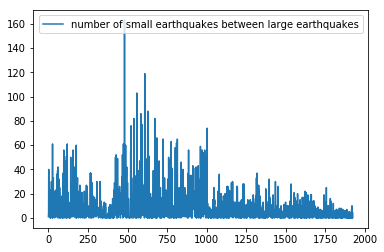

In [26]:
dataset = get_dataset()
print(dataset)
plt.plot(dataset, label = 'number of small earthquakes between large earthquakes')
plt.legend()
plt.savefig('fig6',dpi=1024)
plt.show()

## Configuring and fitting SARIMAX

Configuring a SARIMA requires selecting hyperparameters for trend elements of the series.

### Trend Elements

There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

    p: Trend autoregression order.
    d: Trend difference order.
    q: Trend moving average order.


                           Statespace Model Results                           
Dep. Variable:          timeSinceLast   No. Observations:                 1925
Model:               SARIMAX(5, 0, 1)   Log Likelihood               -7537.420
Date:                Thu, 25 Oct 2018   AIC                          15088.840
Time:                        19:20:59   BIC                          15127.779
Sample:                             0   HQIC                         15103.165
                               - 1925                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0323      0.019     54.364      0.000       0.995       1.070
ar.L2          0.0279      0.025      1.125      0.261      -0.021       0.076
ar.L3         -0.0116      0.025     -0.465      0.6

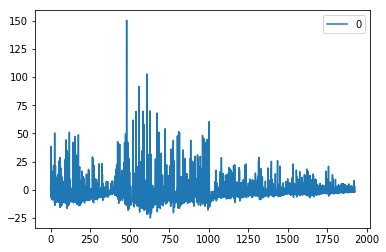

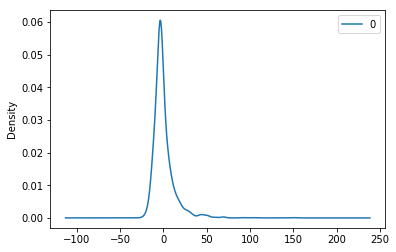

                 0
count  1925.000000
mean      0.074278
std      12.145410
min     -24.959856
25%      -6.093499
50%      -2.589468
75%       3.084706
max     150.506508


In [27]:
model = sm.tsa.statespace.SARIMAX(dataset, order=(5,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

## SAVING CHECKPOINT FOR PREDICTIONS

In [28]:
model_fit.save('arima_nowcasting.pkl')

## Plotting Residual Errors

Residual Errors: 




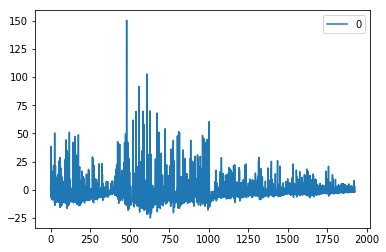

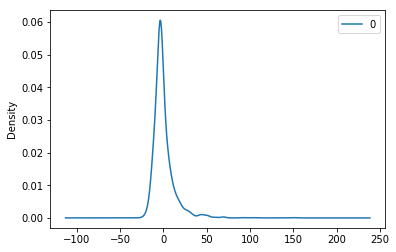

In [29]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
print('Residual Errors: \n\n')
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()

## Residual Description

In [30]:
print('Residual Description')
print(residuals.describe())

Residual Description
                 0
count  1925.000000
mean      0.074278
std      12.145410
min     -24.959856
25%      -6.093499
50%      -2.589468
75%       3.084706
max     150.506508


## Training SARIMAX

The model is trained initially with training data. In each iteration, the model predicts the magnitude of next earthquake. Then, The training data is increased by one by the true value of magnitude of the prediction. The difference in magnitude in prediction and true value is used to get the mean-square-error

  0%|          | 1/655 [00:00<07:37,  1.43it/s]

predicted=6.136836, expected=13.000000


  0%|          | 2/655 [00:01<07:01,  1.55it/s]

predicted=6.209999, expected=2.000000


  0%|          | 3/655 [00:01<06:35,  1.65it/s]

predicted=6.492353, expected=13.000000


  1%|          | 4/655 [00:02<06:36,  1.64it/s]

predicted=6.391196, expected=9.000000


  1%|          | 5/655 [00:03<07:37,  1.42it/s]

predicted=6.807194, expected=0.000000


  1%|          | 6/655 [00:04<08:12,  1.32it/s]

predicted=5.984470, expected=3.000000


  1%|          | 7/655 [00:05<08:23,  1.29it/s]

predicted=5.912334, expected=15.000000


  1%|          | 8/655 [00:06<08:49,  1.22it/s]

predicted=6.037413, expected=6.000000


  1%|▏         | 9/655 [00:07<09:10,  1.17it/s]

predicted=6.076744, expected=0.000000


  2%|▏         | 10/655 [00:08<09:16,  1.16it/s]

predicted=5.941174, expected=1.000000


  2%|▏         | 11/655 [00:09<09:31,  1.13it/s]

predicted=5.764449, expected=5.000000


  2%|▏         | 12/655 [00:11<09:51,  1.09it/s]

predicted=5.119332, expected=1.000000


  2%|▏         | 13/655 [00:11<09:52,  1.08it/s]

predicted=4.825319, expected=2.000000


  2%|▏         | 14/655 [00:13<10:08,  1.05it/s]

predicted=4.801738, expected=13.000000


  2%|▏         | 15/655 [00:14<10:09,  1.05it/s]

predicted=5.463424, expected=4.000000


  2%|▏         | 16/655 [00:15<10:08,  1.05it/s]

predicted=5.602352, expected=3.000000


  3%|▎         | 17/655 [00:16<10:08,  1.05it/s]

predicted=5.552223, expected=3.000000


  3%|▎         | 18/655 [00:17<10:07,  1.05it/s]

predicted=5.640428, expected=1.000000


  3%|▎         | 19/655 [00:18<10:07,  1.05it/s]

predicted=4.884569, expected=0.000000


  3%|▎         | 20/655 [00:19<10:05,  1.05it/s]

predicted=4.555913, expected=0.000000


  3%|▎         | 21/655 [00:20<10:07,  1.04it/s]

predicted=4.291210, expected=0.000000


  3%|▎         | 22/655 [00:21<10:09,  1.04it/s]

predicted=4.023671, expected=0.000000


  4%|▎         | 23/655 [00:22<10:11,  1.03it/s]

predicted=3.869883, expected=2.000000


  4%|▎         | 24/655 [00:23<10:13,  1.03it/s]

predicted=3.892277, expected=2.000000


  4%|▍         | 25/655 [00:24<10:15,  1.02it/s]

predicted=3.969516, expected=3.000000


  4%|▍         | 26/655 [00:25<10:17,  1.02it/s]

predicted=4.076041, expected=19.000000


  4%|▍         | 27/655 [00:26<10:17,  1.02it/s]

predicted=5.147384, expected=1.000000


  4%|▍         | 28/655 [00:27<10:19,  1.01it/s]

predicted=5.455990, expected=0.000000


  4%|▍         | 29/655 [00:28<10:23,  1.00it/s]

predicted=5.034785, expected=0.000000


  5%|▍         | 30/655 [00:30<10:30,  1.01s/it]

predicted=4.918344, expected=12.000000


  5%|▍         | 31/655 [00:31<10:35,  1.02s/it]

predicted=4.381255, expected=12.000000


  5%|▍         | 32/655 [00:32<10:38,  1.02s/it]

predicted=5.223604, expected=0.000000


  5%|▌         | 33/655 [00:33<10:37,  1.02s/it]

predicted=5.266692, expected=2.000000


  5%|▌         | 34/655 [00:34<10:37,  1.03s/it]

predicted=5.242732, expected=2.000000


  5%|▌         | 35/655 [00:36<10:39,  1.03s/it]

predicted=4.706836, expected=8.000000


  5%|▌         | 36/655 [00:37<10:41,  1.04s/it]

predicted=4.371167, expected=1.000000


  6%|▌         | 37/655 [00:38<10:42,  1.04s/it]

predicted=4.531644, expected=2.000000


  6%|▌         | 38/655 [00:39<10:42,  1.04s/it]

predicted=4.373011, expected=9.000000


  6%|▌         | 39/655 [00:40<10:41,  1.04s/it]

predicted=4.795044, expected=8.000000


  6%|▌         | 40/655 [00:41<10:42,  1.04s/it]

predicted=4.885292, expected=16.000000


  6%|▋         | 41/655 [00:42<10:43,  1.05s/it]

predicted=5.749938, expected=0.000000


  6%|▋         | 42/655 [00:44<10:43,  1.05s/it]

predicted=5.913237, expected=18.000000


  7%|▋         | 43/655 [00:45<10:46,  1.06s/it]

predicted=6.158748, expected=13.000000


  7%|▋         | 44/655 [00:46<10:47,  1.06s/it]

predicted=6.940406, expected=16.000000


  7%|▋         | 45/655 [00:47<10:48,  1.06s/it]

predicted=6.859583, expected=3.000000


  7%|▋         | 46/655 [00:49<10:48,  1.07s/it]

predicted=7.338231, expected=33.000000


  7%|▋         | 47/655 [00:50<10:46,  1.06s/it]

predicted=7.999748, expected=5.000000


  7%|▋         | 48/655 [00:51<10:47,  1.07s/it]

predicted=8.380319, expected=10.000000


  7%|▋         | 49/655 [00:52<10:47,  1.07s/it]

predicted=7.504504, expected=10.000000


  8%|▊         | 50/655 [00:53<10:45,  1.07s/it]

predicted=8.340653, expected=37.000000


  8%|▊         | 51/655 [00:54<10:43,  1.07s/it]

predicted=8.419181, expected=15.000000


  8%|▊         | 52/655 [00:55<10:43,  1.07s/it]

predicted=9.825404, expected=1.000000


  8%|▊         | 53/655 [00:56<10:44,  1.07s/it]

predicted=9.064544, expected=5.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
  8%|▊         | 54/655 [00:58<10:47,  1.08s/it]

predicted=8.898593, expected=8.000000


  8%|▊         | 55/655 [00:59<10:49,  1.08s/it]

predicted=7.131563, expected=11.000000


  9%|▊         | 56/655 [01:00<10:50,  1.09s/it]

predicted=6.800701, expected=13.000000


  9%|▊         | 57/655 [01:01<10:49,  1.09s/it]

predicted=7.595567, expected=2.000000


  9%|▉         | 58/655 [01:03<10:48,  1.09s/it]

predicted=7.538589, expected=24.000000


  9%|▉         | 59/655 [01:04<10:47,  1.09s/it]

predicted=8.281131, expected=0.000000


  9%|▉         | 60/655 [01:05<10:46,  1.09s/it]

predicted=8.221322, expected=27.000000


  9%|▉         | 61/655 [01:06<10:44,  1.09s/it]

predicted=8.403317, expected=9.000000


  9%|▉         | 62/655 [01:07<10:43,  1.09s/it]

predicted=9.782342, expected=3.000000


 10%|▉         | 63/655 [01:08<10:43,  1.09s/it]

predicted=8.041233, expected=0.000000


 10%|▉         | 64/655 [01:09<10:41,  1.09s/it]

predicted=8.239016, expected=17.000000


 10%|▉         | 65/655 [01:10<10:40,  1.09s/it]

predicted=7.380296, expected=3.000000


 10%|█         | 66/655 [01:11<10:39,  1.09s/it]

predicted=7.337771, expected=0.000000


 10%|█         | 67/655 [01:12<10:37,  1.08s/it]

predicted=6.800988, expected=11.000000


 10%|█         | 68/655 [01:13<10:35,  1.08s/it]

predicted=7.510678, expected=2.000000


 11%|█         | 69/655 [01:14<10:36,  1.09s/it]

predicted=6.716200, expected=0.000000


 11%|█         | 70/655 [01:15<10:34,  1.09s/it]

predicted=6.264719, expected=18.000000


 11%|█         | 71/655 [01:17<10:34,  1.09s/it]

predicted=7.278905, expected=4.000000


 11%|█         | 72/655 [01:18<10:33,  1.09s/it]

predicted=7.180987, expected=10.000000


 11%|█         | 73/655 [01:19<10:34,  1.09s/it]

predicted=7.311178, expected=2.000000


 11%|█▏        | 74/655 [01:20<10:34,  1.09s/it]

predicted=7.781432, expected=8.000000


 11%|█▏        | 75/655 [01:21<10:33,  1.09s/it]

predicted=6.866001, expected=3.000000


 12%|█▏        | 76/655 [01:23<10:32,  1.09s/it]

predicted=6.986820, expected=0.000000


 12%|█▏        | 77/655 [01:24<10:31,  1.09s/it]

predicted=6.186638, expected=3.000000


 12%|█▏        | 78/655 [01:25<10:31,  1.09s/it]

predicted=6.168459, expected=1.000000


 12%|█▏        | 79/655 [01:26<10:30,  1.09s/it]

predicted=5.700837, expected=5.000000


 12%|█▏        | 80/655 [01:27<10:30,  1.10s/it]

predicted=5.641371, expected=5.000000


 12%|█▏        | 81/655 [01:28<10:29,  1.10s/it]

predicted=5.973463, expected=6.000000


 13%|█▎        | 82/655 [01:29<10:28,  1.10s/it]

predicted=6.069515, expected=4.000000


 13%|█▎        | 83/655 [01:30<10:26,  1.10s/it]

predicted=6.275898, expected=1.000000


 13%|█▎        | 84/655 [01:32<10:26,  1.10s/it]

predicted=5.978134, expected=0.000000


 13%|█▎        | 85/655 [01:33<10:25,  1.10s/it]

predicted=5.587993, expected=2.000000


 13%|█▎        | 86/655 [01:34<10:23,  1.10s/it]

predicted=5.233155, expected=6.000000


 13%|█▎        | 87/655 [01:35<10:22,  1.10s/it]

predicted=5.264682, expected=1.000000


 13%|█▎        | 88/655 [01:36<10:21,  1.10s/it]

predicted=5.284336, expected=2.000000


 14%|█▎        | 89/655 [01:37<10:20,  1.10s/it]

predicted=5.252033, expected=13.000000


 14%|█▎        | 90/655 [01:38<10:19,  1.10s/it]

predicted=5.869030, expected=0.000000


 14%|█▍        | 91/655 [01:39<10:19,  1.10s/it]

predicted=5.718278, expected=0.000000


 14%|█▍        | 92/655 [01:40<10:17,  1.10s/it]

predicted=5.374050, expected=3.000000


 14%|█▍        | 93/655 [01:42<10:17,  1.10s/it]

predicted=5.497125, expected=1.000000


 14%|█▍        | 94/655 [01:43<10:16,  1.10s/it]

predicted=4.669775, expected=0.000000


 15%|█▍        | 95/655 [01:44<10:15,  1.10s/it]

predicted=4.550370, expected=4.000000


 15%|█▍        | 96/655 [01:45<10:14,  1.10s/it]

predicted=4.704314, expected=5.000000


 15%|█▍        | 97/655 [01:46<10:13,  1.10s/it]

predicted=4.815268, expected=4.000000


 15%|█▍        | 98/655 [01:47<10:12,  1.10s/it]

predicted=4.955606, expected=2.000000


 15%|█▌        | 99/655 [01:48<10:11,  1.10s/it]

predicted=5.066359, expected=0.000000


 15%|█▌        | 100/655 [01:49<10:10,  1.10s/it]

predicted=4.772680, expected=2.000000


 15%|█▌        | 101/655 [01:51<10:09,  1.10s/it]

predicted=4.485260, expected=0.000000


 16%|█▌        | 102/655 [01:52<10:09,  1.10s/it]

predicted=4.210644, expected=6.000000


 16%|█▌        | 103/655 [01:53<10:09,  1.10s/it]

predicted=4.294472, expected=6.000000


 16%|█▌        | 104/655 [01:54<10:08,  1.10s/it]

predicted=4.741736, expected=0.000000


 16%|█▌        | 105/655 [01:55<10:07,  1.10s/it]

predicted=4.594615, expected=24.000000


 16%|█▌        | 106/655 [01:57<10:06,  1.11s/it]

predicted=5.841965, expected=8.000000


 16%|█▋        | 107/655 [01:58<10:06,  1.11s/it]

predicted=6.575088, expected=0.000000


 16%|█▋        | 108/655 [01:59<10:04,  1.11s/it]

predicted=5.942774, expected=1.000000


 17%|█▋        | 109/655 [02:00<10:04,  1.11s/it]

predicted=6.121566, expected=7.000000


 17%|█▋        | 110/655 [02:01<10:03,  1.11s/it]

predicted=4.970661, expected=14.000000


 17%|█▋        | 111/655 [02:02<10:02,  1.11s/it]

predicted=5.310557, expected=13.000000


 17%|█▋        | 112/655 [02:03<10:00,  1.11s/it]

predicted=6.244562, expected=1.000000


 17%|█▋        | 113/655 [02:04<09:58,  1.10s/it]

predicted=6.385589, expected=9.000000


 17%|█▋        | 114/655 [02:05<09:57,  1.11s/it]

predicted=6.367722, expected=3.000000


 18%|█▊        | 115/655 [02:07<09:57,  1.11s/it]

predicted=5.932234, expected=3.000000


 18%|█▊        | 116/655 [02:08<09:56,  1.11s/it]

predicted=5.101815, expected=0.000000


 18%|█▊        | 117/655 [02:09<09:55,  1.11s/it]

predicted=5.110126, expected=3.000000


 18%|█▊        | 118/655 [02:10<09:54,  1.11s/it]

predicted=4.584699, expected=2.000000


 18%|█▊        | 119/655 [02:11<09:53,  1.11s/it]

predicted=4.532218, expected=3.000000


 18%|█▊        | 120/655 [02:12<09:52,  1.11s/it]

predicted=4.418943, expected=12.000000


 18%|█▊        | 121/655 [02:13<09:50,  1.11s/it]

predicted=5.098615, expected=1.000000


 19%|█▊        | 122/655 [02:14<09:49,  1.11s/it]

predicted=5.180367, expected=1.000000


 19%|█▉        | 123/655 [02:16<09:48,  1.11s/it]

predicted=4.901299, expected=2.000000


 19%|█▉        | 124/655 [02:17<09:46,  1.11s/it]

predicted=4.912938, expected=8.000000


 19%|█▉        | 125/655 [02:18<09:45,  1.11s/it]

predicted=4.530877, expected=23.000000


 19%|█▉        | 126/655 [02:19<09:44,  1.11s/it]

predicted=5.874601, expected=8.000000


 19%|█▉        | 127/655 [02:20<09:43,  1.11s/it]

predicted=6.699945, expected=32.000000


 20%|█▉        | 128/655 [02:21<09:42,  1.11s/it]

predicted=8.271037, expected=6.000000


 20%|█▉        | 129/655 [02:22<09:41,  1.11s/it]

predicted=9.090804, expected=5.000000


 20%|█▉        | 130/655 [02:23<09:40,  1.11s/it]

predicted=7.495402, expected=17.000000


 20%|██        | 131/655 [02:24<09:39,  1.11s/it]

predicted=8.318367, expected=7.000000


 20%|██        | 132/655 [02:25<09:38,  1.11s/it]

predicted=6.986786, expected=3.000000


 20%|██        | 133/655 [02:27<09:37,  1.11s/it]

predicted=6.653692, expected=1.000000


 20%|██        | 134/655 [02:28<09:36,  1.11s/it]

predicted=6.474949, expected=2.000000


 21%|██        | 135/655 [02:29<09:35,  1.11s/it]

predicted=5.439914, expected=1.000000


 21%|██        | 136/655 [02:30<09:34,  1.11s/it]

predicted=5.013977, expected=1.000000


 21%|██        | 137/655 [02:31<09:33,  1.11s/it]

predicted=4.780299, expected=10.000000


 21%|██        | 138/655 [02:32<09:32,  1.11s/it]

predicted=5.218705, expected=11.000000


 21%|██        | 139/655 [02:34<09:31,  1.11s/it]

predicted=5.887591, expected=1.000000


 21%|██▏       | 140/655 [02:35<09:31,  1.11s/it]

predicted=5.941659, expected=10.000000


 22%|██▏       | 141/655 [02:36<09:29,  1.11s/it]

predicted=6.325907, expected=0.000000


 22%|██▏       | 142/655 [02:37<09:28,  1.11s/it]

predicted=5.981778, expected=2.000000


 22%|██▏       | 143/655 [02:38<09:26,  1.11s/it]

predicted=5.131620, expected=1.000000


 22%|██▏       | 144/655 [02:39<09:26,  1.11s/it]

predicted=5.208427, expected=1.000000


 22%|██▏       | 145/655 [02:40<09:25,  1.11s/it]

predicted=4.511899, expected=8.000000


 22%|██▏       | 146/655 [02:41<09:24,  1.11s/it]

predicted=4.905972, expected=8.000000


 22%|██▏       | 147/655 [02:42<09:22,  1.11s/it]

predicted=5.354780, expected=1.000000


 23%|██▎       | 148/655 [02:43<09:21,  1.11s/it]

predicted=5.362242, expected=0.000000


 23%|██▎       | 149/655 [02:45<09:20,  1.11s/it]

predicted=5.208115, expected=3.000000


 23%|██▎       | 150/655 [02:46<09:19,  1.11s/it]

predicted=4.848975, expected=0.000000


 23%|██▎       | 151/655 [02:47<09:18,  1.11s/it]

predicted=4.331268, expected=11.000000


 23%|██▎       | 152/655 [02:48<09:17,  1.11s/it]

predicted=4.750167, expected=19.000000


 23%|██▎       | 153/655 [02:49<09:16,  1.11s/it]

predicted=6.084055, expected=7.000000


 24%|██▎       | 154/655 [02:51<09:16,  1.11s/it]

predicted=6.544136, expected=2.000000


 24%|██▎       | 155/655 [02:52<09:16,  1.11s/it]

predicted=6.593796, expected=7.000000


 24%|██▍       | 156/655 [02:54<09:16,  1.12s/it]

predicted=6.372389, expected=4.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 24%|██▍       | 157/655 [02:55<09:16,  1.12s/it]

predicted=5.521379, expected=1.000000


 24%|██▍       | 158/655 [02:56<09:15,  1.12s/it]

predicted=5.055594, expected=5.000000


 24%|██▍       | 159/655 [02:58<09:15,  1.12s/it]

predicted=5.169387, expected=3.000000


 24%|██▍       | 160/655 [02:59<09:14,  1.12s/it]

predicted=4.965008, expected=0.000000


 25%|██▍       | 161/655 [03:00<09:13,  1.12s/it]

predicted=4.630417, expected=0.000000


 25%|██▍       | 162/655 [03:01<09:12,  1.12s/it]

predicted=4.490383, expected=0.000000


 25%|██▍       | 163/655 [03:02<09:12,  1.12s/it]

predicted=4.113684, expected=1.000000


 25%|██▌       | 164/655 [03:04<09:11,  1.12s/it]

predicted=3.888285, expected=2.000000


 25%|██▌       | 165/655 [03:05<09:10,  1.12s/it]

predicted=3.943253, expected=4.000000


 25%|██▌       | 166/655 [03:06<09:09,  1.12s/it]

predicted=4.126803, expected=30.000000


 25%|██▌       | 167/655 [03:07<09:08,  1.12s/it]

predicted=5.850167, expected=1.000000


 26%|██▌       | 168/655 [03:08<09:07,  1.12s/it]

predicted=6.529680, expected=6.000000


 26%|██▌       | 169/655 [03:10<09:06,  1.12s/it]

predicted=6.258212, expected=10.000000


 26%|██▌       | 170/655 [03:11<09:05,  1.13s/it]

predicted=6.999678, expected=1.000000


 26%|██▌       | 171/655 [03:12<09:04,  1.13s/it]

predicted=5.226687, expected=5.000000


 26%|██▋       | 172/655 [03:13<09:03,  1.13s/it]

predicted=5.299604, expected=3.000000


 26%|██▋       | 173/655 [03:14<09:02,  1.13s/it]

predicted=5.232425, expected=3.000000


 27%|██▋       | 174/655 [03:15<09:01,  1.13s/it]

predicted=4.690995, expected=8.000000


 27%|██▋       | 175/655 [03:17<09:00,  1.13s/it]

predicted=5.084221, expected=10.000000


 27%|██▋       | 176/655 [03:18<09:00,  1.13s/it]

predicted=5.449878, expected=7.000000


 27%|██▋       | 177/655 [03:19<08:59,  1.13s/it]

predicted=5.752705, expected=3.000000


 27%|██▋       | 178/655 [03:20<08:57,  1.13s/it]

predicted=5.771332, expected=0.000000


 27%|██▋       | 179/655 [03:21<08:56,  1.13s/it]

predicted=5.259998, expected=2.000000


 27%|██▋       | 180/655 [03:23<08:55,  1.13s/it]

predicted=4.680403, expected=13.000000


 28%|██▊       | 181/655 [03:24<08:54,  1.13s/it]

predicted=4.971739, expected=26.000000


 28%|██▊       | 182/655 [03:25<08:54,  1.13s/it]

predicted=6.498691, expected=1.000000


 28%|██▊       | 183/655 [03:26<08:53,  1.13s/it]

predicted=6.969394, expected=3.000000


 28%|██▊       | 184/655 [03:28<08:52,  1.13s/it]

predicted=6.705141, expected=1.000000


 28%|██▊       | 185/655 [03:29<08:52,  1.13s/it]

predicted=6.213448, expected=4.000000


 28%|██▊       | 186/655 [03:30<08:51,  1.13s/it]

predicted=4.686007, expected=7.000000


 29%|██▊       | 187/655 [03:32<08:50,  1.13s/it]

predicted=5.054185, expected=4.000000


 29%|██▊       | 188/655 [03:33<08:50,  1.13s/it]

predicted=5.132438, expected=7.000000


 29%|██▉       | 189/655 [03:34<08:48,  1.14s/it]

predicted=5.420632, expected=4.000000


 29%|██▉       | 190/655 [03:35<08:48,  1.14s/it]

predicted=5.508923, expected=4.000000


 29%|██▉       | 191/655 [03:37<08:47,  1.14s/it]

predicted=5.245342, expected=0.000000


 29%|██▉       | 192/655 [03:38<08:46,  1.14s/it]

predicted=5.027563, expected=2.000000


 29%|██▉       | 193/655 [03:39<08:46,  1.14s/it]

predicted=4.592986, expected=4.000000


 30%|██▉       | 194/655 [03:41<08:45,  1.14s/it]

predicted=4.578838, expected=2.000000


 30%|██▉       | 195/655 [03:42<08:44,  1.14s/it]

predicted=4.424073, expected=2.000000


 30%|██▉       | 196/655 [03:43<08:43,  1.14s/it]

predicted=4.464558, expected=2.000000


 30%|███       | 197/655 [03:45<08:43,  1.14s/it]

predicted=4.435141, expected=8.000000


 30%|███       | 198/655 [03:46<08:42,  1.14s/it]

predicted=4.598827, expected=1.000000


 30%|███       | 199/655 [03:47<08:41,  1.14s/it]

predicted=4.646278, expected=0.000000


 31%|███       | 200/655 [03:48<08:40,  1.14s/it]

predicted=4.360595, expected=2.000000


 31%|███       | 201/655 [03:50<08:39,  1.15s/it]

predicted=4.345817, expected=0.000000


 31%|███       | 202/655 [03:51<08:39,  1.15s/it]

predicted=3.819156, expected=10.000000


 31%|███       | 203/655 [03:52<08:38,  1.15s/it]

predicted=4.216942, expected=0.000000


 31%|███       | 204/655 [03:53<08:37,  1.15s/it]

predicted=4.422085, expected=5.000000


 31%|███▏      | 205/655 [03:55<08:36,  1.15s/it]

predicted=4.344882, expected=3.000000


 31%|███▏      | 206/655 [03:56<08:35,  1.15s/it]

predicted=4.690037, expected=0.000000


 32%|███▏      | 207/655 [03:57<08:34,  1.15s/it]

predicted=3.976606, expected=4.000000


 32%|███▏      | 208/655 [03:59<08:34,  1.15s/it]

predicted=4.140304, expected=2.000000


 32%|███▏      | 209/655 [04:00<08:33,  1.15s/it]

predicted=4.001050, expected=3.000000


 32%|███▏      | 210/655 [04:02<08:33,  1.15s/it]

predicted=3.895516, expected=0.000000


 32%|███▏      | 211/655 [04:03<08:32,  1.16s/it]

predicted=3.914631, expected=1.000000


 32%|███▏      | 212/655 [04:04<08:31,  1.16s/it]

predicted=3.619522, expected=5.000000


 33%|███▎      | 213/655 [04:06<08:30,  1.16s/it]

predicted=3.767791, expected=4.000000


 33%|███▎      | 214/655 [04:07<08:29,  1.16s/it]

predicted=3.849221, expected=1.000000


 33%|███▎      | 215/655 [04:08<08:28,  1.16s/it]

predicted=3.872641, expected=3.000000


 33%|███▎      | 216/655 [04:09<08:27,  1.16s/it]

predicted=3.933094, expected=6.000000


 33%|███▎      | 217/655 [04:10<08:26,  1.16s/it]

predicted=3.999547, expected=0.000000


 33%|███▎      | 218/655 [04:12<08:25,  1.16s/it]

predicted=3.796455, expected=1.000000


 33%|███▎      | 219/655 [04:13<08:24,  1.16s/it]

predicted=3.660939, expected=11.000000


 34%|███▎      | 220/655 [04:14<08:23,  1.16s/it]

predicted=4.129952, expected=1.000000


 34%|███▎      | 221/655 [04:16<08:22,  1.16s/it]

predicted=4.009905, expected=0.000000


 34%|███▍      | 222/655 [04:17<08:21,  1.16s/it]

predicted=3.808744, expected=10.000000


 34%|███▍      | 223/655 [04:18<08:20,  1.16s/it]

predicted=4.361653, expected=1.000000


 34%|███▍      | 224/655 [04:19<08:19,  1.16s/it]

predicted=3.925856, expected=9.000000


 34%|███▍      | 225/655 [04:20<08:18,  1.16s/it]

predicted=4.182517, expected=1.000000


 35%|███▍      | 226/655 [04:21<08:17,  1.16s/it]

predicted=4.508481, expected=1.000000


 35%|███▍      | 227/655 [04:23<08:15,  1.16s/it]

predicted=3.762726, expected=0.000000


 35%|███▍      | 228/655 [04:24<08:14,  1.16s/it]

predicted=3.745207, expected=1.000000


 35%|███▍      | 229/655 [04:25<08:13,  1.16s/it]

predicted=3.160088, expected=4.000000


 35%|███▌      | 230/655 [04:26<08:12,  1.16s/it]

predicted=3.296002, expected=13.000000


 35%|███▌      | 231/655 [04:27<08:11,  1.16s/it]

predicted=3.997637, expected=2.000000


 35%|███▌      | 232/655 [04:29<08:10,  1.16s/it]

predicted=4.337555, expected=1.000000


 36%|███▌      | 233/655 [04:30<08:09,  1.16s/it]

predicted=4.163775, expected=3.000000


 36%|███▌      | 234/655 [04:31<08:08,  1.16s/it]

predicted=4.161414, expected=3.000000


 36%|███▌      | 235/655 [04:32<08:07,  1.16s/it]

predicted=3.530910, expected=5.000000


 36%|███▌      | 236/655 [04:33<08:06,  1.16s/it]

predicted=3.666871, expected=10.000000


 36%|███▌      | 237/655 [04:34<08:05,  1.16s/it]

predicted=4.227730, expected=5.000000


 36%|███▋      | 238/655 [04:36<08:03,  1.16s/it]

predicted=4.476259, expected=9.000000


 36%|███▋      | 239/655 [04:37<08:02,  1.16s/it]

predicted=4.769690, expected=1.000000


 37%|███▋      | 240/655 [04:38<08:01,  1.16s/it]

predicted=4.717718, expected=4.000000


 37%|███▋      | 241/655 [04:39<08:00,  1.16s/it]

predicted=4.191471, expected=2.000000


 37%|███▋      | 242/655 [04:40<07:59,  1.16s/it]

predicted=4.115475, expected=1.000000


 37%|███▋      | 243/655 [04:42<07:58,  1.16s/it]

predicted=3.538434, expected=9.000000


 37%|███▋      | 244/655 [04:43<07:57,  1.16s/it]

predicted=3.960508, expected=10.000000


 37%|███▋      | 245/655 [04:44<07:55,  1.16s/it]

predicted=4.453633, expected=8.000000


 38%|███▊      | 246/655 [04:45<07:54,  1.16s/it]

predicted=4.851081, expected=8.000000


 38%|███▊      | 247/655 [04:46<07:53,  1.16s/it]

predicted=5.332753, expected=1.000000


 38%|███▊      | 248/655 [04:47<07:52,  1.16s/it]

predicted=4.951479, expected=9.000000


 38%|███▊      | 249/655 [04:48<07:51,  1.16s/it]

predicted=4.758472, expected=0.000000


 38%|███▊      | 250/655 [04:50<07:49,  1.16s/it]

predicted=4.496620, expected=0.000000


 38%|███▊      | 251/655 [04:51<07:48,  1.16s/it]

predicted=3.792457, expected=5.000000


 38%|███▊      | 252/655 [04:52<07:47,  1.16s/it]

predicted=4.043675, expected=6.000000


 39%|███▊      | 253/655 [04:53<07:46,  1.16s/it]

predicted=3.880533, expected=10.000000


 39%|███▉      | 254/655 [04:54<07:44,  1.16s/it]

predicted=4.458696, expected=3.000000


 39%|███▉      | 255/655 [04:55<07:43,  1.16s/it]

predicted=4.783325, expected=1.000000


 39%|███▉      | 256/655 [04:56<07:42,  1.16s/it]

predicted=4.445943, expected=0.000000


 39%|███▉      | 257/655 [04:58<07:41,  1.16s/it]

predicted=4.091244, expected=1.000000


 39%|███▉      | 258/655 [04:59<07:40,  1.16s/it]

predicted=3.468697, expected=0.000000


 40%|███▉      | 259/655 [05:00<07:39,  1.16s/it]

predicted=3.247264, expected=14.000000


 40%|███▉      | 260/655 [05:01<07:38,  1.16s/it]

predicted=3.897375, expected=2.000000


 40%|███▉      | 261/655 [05:02<07:37,  1.16s/it]

predicted=4.319710, expected=2.000000


 40%|████      | 262/655 [05:04<07:36,  1.16s/it]

predicted=4.133679, expected=10.000000


 40%|████      | 263/655 [05:05<07:34,  1.16s/it]

predicted=4.812965, expected=7.000000


 40%|████      | 264/655 [05:06<07:33,  1.16s/it]

predicted=4.519892, expected=12.000000


 40%|████      | 265/655 [05:07<07:32,  1.16s/it]

predicted=5.058785, expected=28.000000


 41%|████      | 266/655 [05:08<07:31,  1.16s/it]

predicted=6.789362, expected=0.000000


 41%|████      | 267/655 [05:09<07:30,  1.16s/it]

predicted=6.700172, expected=0.000000


 41%|████      | 268/655 [05:10<07:29,  1.16s/it]

predicted=5.885950, expected=1.000000


 41%|████      | 269/655 [05:12<07:28,  1.16s/it]

predicted=5.413057, expected=1.000000


 41%|████      | 270/655 [05:13<07:27,  1.16s/it]

predicted=3.681843, expected=5.000000


 41%|████▏     | 271/655 [05:14<07:26,  1.16s/it]

predicted=3.899044, expected=5.000000


 42%|████▏     | 272/655 [05:15<07:24,  1.16s/it]

predicted=4.230399, expected=10.000000


 42%|████▏     | 273/655 [05:17<07:23,  1.16s/it]

predicted=4.725475, expected=2.000000


 42%|████▏     | 274/655 [05:18<07:22,  1.16s/it]

predicted=4.930221, expected=4.000000


 42%|████▏     | 275/655 [05:19<07:22,  1.16s/it]

predicted=4.722859, expected=1.000000


 42%|████▏     | 276/655 [05:21<07:21,  1.16s/it]

predicted=4.570099, expected=3.000000


 42%|████▏     | 277/655 [05:22<07:19,  1.16s/it]

predicted=4.034471, expected=7.000000


 42%|████▏     | 278/655 [05:23<07:19,  1.16s/it]

predicted=4.338454, expected=9.000000


 43%|████▎     | 279/655 [05:24<07:17,  1.16s/it]

predicted=4.675789, expected=1.000000


 43%|████▎     | 280/655 [05:26<07:17,  1.17s/it]

predicted=4.744510, expected=5.000000


 43%|████▎     | 281/655 [05:27<07:15,  1.17s/it]

predicted=4.728660, expected=2.000000


 43%|████▎     | 282/655 [05:28<07:14,  1.17s/it]

predicted=4.543326, expected=0.000000


 43%|████▎     | 283/655 [05:29<07:13,  1.17s/it]

predicted=3.897458, expected=0.000000


 43%|████▎     | 284/655 [05:31<07:12,  1.17s/it]

predicted=3.780641, expected=0.000000


 44%|████▎     | 285/655 [05:32<07:11,  1.17s/it]

predicted=3.419269, expected=21.000000


 44%|████▎     | 286/655 [05:33<07:10,  1.17s/it]

predicted=4.427440, expected=10.000000


 44%|████▍     | 287/655 [05:35<07:09,  1.17s/it]

predicted=5.461137, expected=1.000000


 44%|████▍     | 288/655 [05:36<07:08,  1.17s/it]

predicted=5.363275, expected=17.000000


 44%|████▍     | 289/655 [05:37<07:07,  1.17s/it]

predicted=6.355423, expected=0.000000


 44%|████▍     | 290/655 [05:39<07:06,  1.17s/it]

predicted=5.506501, expected=10.000000


 44%|████▍     | 291/655 [05:40<07:05,  1.17s/it]

predicted=5.143379, expected=0.000000


 45%|████▍     | 292/655 [05:41<07:04,  1.17s/it]

predicted=5.425678, expected=3.000000


 45%|████▍     | 293/655 [05:42<07:03,  1.17s/it]

predicted=4.326927, expected=5.000000


 45%|████▍     | 294/655 [05:43<07:02,  1.17s/it]

predicted=4.704855, expected=5.000000


 45%|████▌     | 295/655 [05:45<07:01,  1.17s/it]

predicted=4.385582, expected=5.000000


 45%|████▌     | 296/655 [05:46<07:00,  1.17s/it]

predicted=4.671261, expected=14.000000


 45%|████▌     | 297/655 [05:47<06:59,  1.17s/it]

predicted=5.306108, expected=1.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 45%|████▌     | 298/655 [05:49<06:58,  1.17s/it]

predicted=5.313846, expected=4.000000


 46%|████▌     | 299/655 [05:51<06:57,  1.17s/it]

predicted=5.014085, expected=2.000000


 46%|████▌     | 300/655 [05:52<06:56,  1.17s/it]

predicted=4.966774, expected=2.000000


 46%|████▌     | 301/655 [05:53<06:55,  1.17s/it]

predicted=4.150507, expected=3.000000


 46%|████▌     | 302/655 [05:54<06:54,  1.18s/it]

predicted=4.238687, expected=6.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 46%|████▋     | 303/655 [05:56<06:54,  1.18s/it]

predicted=4.323971, expected=0.000000


 46%|████▋     | 304/655 [05:58<06:53,  1.18s/it]

predicted=4.252371, expected=0.000000


 47%|████▋     | 305/655 [05:59<06:52,  1.18s/it]

predicted=3.988033, expected=0.000000


 47%|████▋     | 306/655 [06:00<06:51,  1.18s/it]

predicted=3.785597, expected=20.000000


 47%|████▋     | 307/655 [06:02<06:50,  1.18s/it]

predicted=4.481829, expected=4.000000


 47%|████▋     | 308/655 [06:03<06:49,  1.18s/it]

predicted=5.151432, expected=5.000000


 47%|████▋     | 309/655 [06:04<06:48,  1.18s/it]

predicted=5.150360, expected=0.000000


 47%|████▋     | 310/655 [06:06<06:47,  1.18s/it]

predicted=5.341827, expected=3.000000


 47%|████▋     | 311/655 [06:07<06:46,  1.18s/it]

predicted=4.179117, expected=4.000000


 48%|████▊     | 312/655 [06:08<06:45,  1.18s/it]

predicted=4.214071, expected=1.000000


 48%|████▊     | 313/655 [06:09<06:44,  1.18s/it]

predicted=3.946121, expected=11.000000


 48%|████▊     | 314/655 [06:11<06:43,  1.18s/it]

predicted=4.485538, expected=1.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 48%|████▊     | 315/655 [06:13<06:42,  1.18s/it]

predicted=4.595997, expected=5.000000


 48%|████▊     | 316/655 [06:14<06:41,  1.18s/it]

predicted=4.421877, expected=1.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 48%|████▊     | 317/655 [06:16<06:41,  1.19s/it]

predicted=4.568280, expected=6.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 49%|████▊     | 318/655 [06:17<06:40,  1.19s/it]

predicted=4.120084, expected=1.000000


 49%|████▊     | 319/655 [06:19<06:39,  1.19s/it]

predicted=4.233544, expected=2.000000


 49%|████▉     | 320/655 [06:20<06:38,  1.19s/it]

predicted=3.907020, expected=1.000000


 49%|████▉     | 321/655 [06:22<06:37,  1.19s/it]

predicted=3.927394, expected=6.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 49%|████▉     | 322/655 [06:24<06:37,  1.19s/it]

predicted=3.832916, expected=15.000000


 49%|████▉     | 323/655 [06:25<06:36,  1.19s/it]

predicted=4.711352, expected=0.000000


 49%|████▉     | 324/655 [06:27<06:35,  1.19s/it]

predicted=4.821632, expected=3.000000


 50%|████▉     | 325/655 [06:28<06:34,  1.20s/it]

predicted=4.678754, expected=1.000000


 50%|████▉     | 326/655 [06:29<06:33,  1.20s/it]

predicted=4.530763, expected=0.000000


 50%|████▉     | 327/655 [06:31<06:32,  1.20s/it]

predicted=3.524903, expected=10.000000


 50%|█████     | 328/655 [06:32<06:31,  1.20s/it]

predicted=4.031050, expected=0.000000


 50%|█████     | 329/655 [06:33<06:30,  1.20s/it]

predicted=4.049331, expected=2.000000


 50%|█████     | 330/655 [06:35<06:29,  1.20s/it]

predicted=3.868923, expected=1.000000


 51%|█████     | 331/655 [06:36<06:28,  1.20s/it]

predicted=4.007175, expected=6.000000


 51%|█████     | 332/655 [06:37<06:27,  1.20s/it]

predicted=3.664251, expected=0.000000


 51%|█████     | 333/655 [06:39<06:25,  1.20s/it]

predicted=3.755348, expected=0.000000


 51%|█████     | 334/655 [06:40<06:24,  1.20s/it]

predicted=3.477917, expected=6.000000


 51%|█████     | 335/655 [06:41<06:23,  1.20s/it]

predicted=3.748413, expected=0.000000


 51%|█████▏    | 336/655 [06:43<06:22,  1.20s/it]

predicted=3.473687, expected=17.000000


 51%|█████▏    | 337/655 [06:44<06:21,  1.20s/it]

predicted=4.266277, expected=9.000000


 52%|█████▏    | 338/655 [06:45<06:20,  1.20s/it]

predicted=5.218156, expected=4.000000


 52%|█████▏    | 339/655 [06:47<06:19,  1.20s/it]

predicted=4.975134, expected=10.000000


 52%|█████▏    | 340/655 [06:48<06:18,  1.20s/it]

predicted=5.599577, expected=2.000000


 52%|█████▏    | 341/655 [06:49<06:17,  1.20s/it]

predicted=4.903850, expected=2.000000


 52%|█████▏    | 342/655 [06:51<06:16,  1.20s/it]

predicted=4.334452, expected=13.000000


 52%|█████▏    | 343/655 [06:52<06:15,  1.20s/it]

predicted=4.868901, expected=3.000000


 53%|█████▎    | 344/655 [06:53<06:13,  1.20s/it]

predicted=4.695233, expected=3.000000


 53%|█████▎    | 345/655 [06:54<06:12,  1.20s/it]

predicted=4.563467, expected=0.000000


 53%|█████▎    | 346/655 [06:56<06:11,  1.20s/it]

predicted=4.522505, expected=17.000000


 53%|█████▎    | 347/655 [06:57<06:10,  1.20s/it]

predicted=4.601820, expected=2.000000


 53%|█████▎    | 348/655 [06:58<06:09,  1.20s/it]

predicted=4.940147, expected=2.000000


 53%|█████▎    | 349/655 [06:59<06:08,  1.20s/it]

predicted=4.580536, expected=0.000000


 53%|█████▎    | 350/655 [07:01<06:07,  1.20s/it]

predicted=4.697636, expected=2.000000


 54%|█████▎    | 351/655 [07:02<06:05,  1.20s/it]

predicted=3.693272, expected=1.000000


 54%|█████▎    | 352/655 [07:03<06:04,  1.20s/it]

predicted=3.626791, expected=22.000000


 54%|█████▍    | 353/655 [07:04<06:03,  1.20s/it]

predicted=4.656703, expected=0.000000


 54%|█████▍    | 354/655 [07:06<06:02,  1.20s/it]

predicted=5.175607, expected=0.000000


 54%|█████▍    | 355/655 [07:07<06:00,  1.20s/it]

predicted=4.639458, expected=8.000000


 54%|█████▍    | 356/655 [07:08<05:59,  1.20s/it]

predicted=5.172088, expected=7.000000


 55%|█████▍    | 357/655 [07:09<05:58,  1.20s/it]

predicted=4.369195, expected=3.000000


 55%|█████▍    | 358/655 [07:10<05:57,  1.20s/it]

predicted=4.522775, expected=4.000000


 55%|█████▍    | 359/655 [07:12<05:56,  1.20s/it]

predicted=4.722287, expected=21.000000


 55%|█████▍    | 360/655 [07:13<05:55,  1.20s/it]

predicted=5.459017, expected=0.000000


 55%|█████▌    | 361/655 [07:14<05:53,  1.20s/it]

predicted=5.483973, expected=0.000000


 55%|█████▌    | 362/655 [07:15<05:52,  1.20s/it]

predicted=4.949664, expected=9.000000


 55%|█████▌    | 363/655 [07:16<05:51,  1.20s/it]

predicted=5.336786, expected=4.000000


 56%|█████▌    | 364/655 [07:18<05:50,  1.20s/it]

predicted=4.440010, expected=0.000000


 56%|█████▌    | 365/655 [07:19<05:49,  1.20s/it]

predicted=4.336715, expected=15.000000


 56%|█████▌    | 366/655 [07:20<05:48,  1.20s/it]

predicted=5.114316, expected=8.000000


 56%|█████▌    | 367/655 [07:22<05:46,  1.20s/it]

predicted=5.365174, expected=10.000000


 56%|█████▌    | 368/655 [07:23<05:45,  1.21s/it]

predicted=5.594066, expected=11.000000


 56%|█████▋    | 369/655 [07:24<05:44,  1.21s/it]

predicted=6.413896, expected=2.000000


 56%|█████▋    | 370/655 [07:25<05:43,  1.21s/it]

predicted=5.757589, expected=18.000000


 57%|█████▋    | 371/655 [07:27<05:42,  1.21s/it]

predicted=6.171625, expected=19.000000


 57%|█████▋    | 372/655 [07:28<05:41,  1.21s/it]

predicted=7.086656, expected=0.000000


 57%|█████▋    | 373/655 [07:29<05:39,  1.21s/it]

predicted=6.599333, expected=1.000000


 57%|█████▋    | 374/655 [07:31<05:38,  1.21s/it]

predicted=6.346668, expected=4.000000


 57%|█████▋    | 375/655 [07:32<05:37,  1.21s/it]

predicted=5.582520, expected=4.000000


 57%|█████▋    | 376/655 [07:33<05:36,  1.21s/it]

predicted=4.651557, expected=5.000000


 58%|█████▊    | 377/655 [07:34<05:35,  1.21s/it]

predicted=4.896546, expected=14.000000


 58%|█████▊    | 378/655 [07:36<05:34,  1.21s/it]

predicted=5.635183, expected=6.000000


 58%|█████▊    | 379/655 [07:37<05:33,  1.21s/it]

predicted=5.963473, expected=6.000000


 58%|█████▊    | 380/655 [07:39<05:32,  1.21s/it]

predicted=5.975091, expected=5.000000


 58%|█████▊    | 381/655 [07:40<05:31,  1.21s/it]

predicted=6.056409, expected=1.000000


 58%|█████▊    | 382/655 [07:42<05:30,  1.21s/it]

predicted=5.277483, expected=0.000000


 58%|█████▊    | 383/655 [07:43<05:29,  1.21s/it]

predicted=4.833910, expected=3.000000


 59%|█████▊    | 384/655 [07:44<05:28,  1.21s/it]

predicted=4.577888, expected=0.000000


 59%|█████▉    | 385/655 [07:46<05:26,  1.21s/it]

predicted=4.271545, expected=0.000000


 59%|█████▉    | 386/655 [07:47<05:25,  1.21s/it]

predicted=4.079987, expected=7.000000


 59%|█████▉    | 387/655 [07:48<05:24,  1.21s/it]

predicted=4.409468, expected=1.000000


 59%|█████▉    | 388/655 [07:49<05:23,  1.21s/it]

predicted=4.377101, expected=14.000000


 59%|█████▉    | 389/655 [07:51<05:22,  1.21s/it]

predicted=5.002537, expected=19.000000


 60%|█████▉    | 390/655 [07:52<05:21,  1.21s/it]

predicted=6.384474, expected=3.000000


 60%|█████▉    | 391/655 [07:54<05:20,  1.21s/it]

predicted=6.348809, expected=5.000000


 60%|█████▉    | 392/655 [07:55<05:18,  1.21s/it]

predicted=6.418553, expected=10.000000


 60%|██████    | 393/655 [07:56<05:17,  1.21s/it]

predicted=6.295093, expected=19.000000


 60%|██████    | 394/655 [07:58<05:16,  1.21s/it]

predicted=6.340864, expected=1.000000


 60%|██████    | 395/655 [07:59<05:15,  1.21s/it]

predicted=6.510344, expected=4.000000


 60%|██████    | 396/655 [08:00<05:14,  1.21s/it]

predicted=6.206342, expected=7.000000


 61%|██████    | 397/655 [08:02<05:13,  1.22s/it]

predicted=6.155633, expected=0.000000


 61%|██████    | 398/655 [08:03<05:12,  1.22s/it]

predicted=5.043965, expected=3.000000


 61%|██████    | 399/655 [08:05<05:11,  1.22s/it]

predicted=5.000455, expected=5.000000


 61%|██████    | 400/655 [08:06<05:10,  1.22s/it]

predicted=5.079950, expected=1.000000


 61%|██████    | 401/655 [08:07<05:08,  1.22s/it]

predicted=4.707064, expected=3.000000


 61%|██████▏   | 402/655 [08:09<05:07,  1.22s/it]

predicted=4.768669, expected=0.000000


 62%|██████▏   | 403/655 [08:10<05:06,  1.22s/it]

predicted=4.602172, expected=3.000000


 62%|██████▏   | 404/655 [08:11<05:05,  1.22s/it]

predicted=4.348306, expected=4.000000


 62%|██████▏   | 405/655 [08:13<05:04,  1.22s/it]

predicted=4.524323, expected=14.000000


 62%|██████▏   | 406/655 [08:14<05:03,  1.22s/it]

predicted=5.101145, expected=1.000000


 62%|██████▏   | 407/655 [08:15<05:02,  1.22s/it]

predicted=5.394652, expected=9.000000


 62%|██████▏   | 408/655 [08:16<05:00,  1.22s/it]

predicted=5.506997, expected=4.000000


 62%|██████▏   | 409/655 [08:18<04:59,  1.22s/it]

predicted=5.737837, expected=4.000000


 63%|██████▎   | 410/655 [08:19<04:58,  1.22s/it]

predicted=5.020707, expected=14.000000


 63%|██████▎   | 411/655 [08:21<04:57,  1.22s/it]

predicted=5.777457, expected=8.000000


 63%|██████▎   | 412/655 [08:22<04:56,  1.22s/it]

predicted=5.929193, expected=2.000000


 63%|██████▎   | 413/655 [08:23<04:55,  1.22s/it]

predicted=5.766828, expected=1.000000


 63%|██████▎   | 414/655 [08:25<04:54,  1.22s/it]

predicted=5.558346, expected=5.000000


 63%|██████▎   | 415/655 [08:26<04:52,  1.22s/it]

predicted=4.971369, expected=10.000000


 64%|██████▎   | 416/655 [08:27<04:51,  1.22s/it]

predicted=5.087030, expected=1.000000


 64%|██████▎   | 417/655 [08:29<04:50,  1.22s/it]

predicted=5.127206, expected=2.000000


 64%|██████▍   | 418/655 [08:30<04:49,  1.22s/it]

predicted=5.030843, expected=4.000000


 64%|██████▍   | 419/655 [08:31<04:48,  1.22s/it]

predicted=4.988122, expected=1.000000


 64%|██████▍   | 420/655 [08:33<04:47,  1.22s/it]

predicted=4.434593, expected=2.000000


 64%|██████▍   | 421/655 [08:34<04:46,  1.22s/it]

predicted=4.389801, expected=0.000000


 64%|██████▍   | 422/655 [08:35<04:44,  1.22s/it]

predicted=4.254606, expected=5.000000


 65%|██████▍   | 423/655 [08:37<04:43,  1.22s/it]

predicted=4.190629, expected=3.000000


 65%|██████▍   | 424/655 [08:39<04:42,  1.22s/it]

predicted=4.356291, expected=5.000000


 65%|██████▍   | 425/655 [08:40<04:41,  1.23s/it]

predicted=4.443281, expected=1.000000


 65%|██████▌   | 426/655 [08:42<04:40,  1.23s/it]

predicted=4.547552, expected=3.000000


 65%|██████▌   | 427/655 [08:43<04:39,  1.23s/it]

predicted=4.318811, expected=0.000000


 65%|██████▌   | 428/655 [08:45<04:38,  1.23s/it]

predicted=4.162384, expected=8.000000


 65%|██████▌   | 429/655 [08:46<04:37,  1.23s/it]

predicted=4.197507, expected=0.000000


 66%|██████▌   | 430/655 [08:47<04:36,  1.23s/it]

predicted=4.285089, expected=2.000000


 66%|██████▌   | 431/655 [08:48<04:34,  1.23s/it]

predicted=4.033941, expected=1.000000


 66%|██████▌   | 432/655 [08:50<04:33,  1.23s/it]

predicted=4.132818, expected=0.000000


 66%|██████▌   | 433/655 [08:51<04:32,  1.23s/it]

predicted=3.570906, expected=0.000000


 66%|██████▋   | 434/655 [08:53<04:31,  1.23s/it]

predicted=3.499060, expected=0.000000


 66%|██████▋   | 435/655 [08:54<04:30,  1.23s/it]

predicted=3.312071, expected=9.000000


 67%|██████▋   | 436/655 [08:55<04:29,  1.23s/it]

predicted=3.682907, expected=0.000000


 67%|██████▋   | 437/655 [08:57<04:27,  1.23s/it]

predicted=3.837458, expected=2.000000


 67%|██████▋   | 438/655 [08:58<04:26,  1.23s/it]

predicted=3.762211, expected=0.000000


 67%|██████▋   | 439/655 [08:59<04:25,  1.23s/it]

predicted=3.820745, expected=1.000000


 67%|██████▋   | 440/655 [09:00<04:24,  1.23s/it]

predicted=3.234883, expected=0.000000


 67%|██████▋   | 441/655 [09:02<04:23,  1.23s/it]

predicted=3.208232, expected=2.000000


 67%|██████▋   | 442/655 [09:03<04:21,  1.23s/it]

predicted=3.118769, expected=7.000000


 68%|██████▊   | 443/655 [09:04<04:20,  1.23s/it]

predicted=3.503859, expected=1.000000


 68%|██████▊   | 444/655 [09:06<04:19,  1.23s/it]

predicted=3.583200, expected=1.000000


 68%|██████▊   | 445/655 [09:07<04:18,  1.23s/it]

predicted=3.525760, expected=3.000000


 68%|██████▊   | 446/655 [09:08<04:17,  1.23s/it]

predicted=3.581934, expected=3.000000


 68%|██████▊   | 447/655 [09:10<04:15,  1.23s/it]

predicted=3.332903, expected=6.000000


 68%|██████▊   | 448/655 [09:11<04:14,  1.23s/it]

predicted=3.589691, expected=0.000000


 69%|██████▊   | 449/655 [09:12<04:13,  1.23s/it]

predicted=3.603722, expected=1.000000


 69%|██████▊   | 450/655 [09:14<04:12,  1.23s/it]

predicted=3.363540, expected=0.000000


 69%|██████▉   | 451/655 [09:15<04:11,  1.23s/it]

predicted=3.196251, expected=0.000000


 69%|██████▉   | 452/655 [09:16<04:10,  1.23s/it]

predicted=2.757220, expected=7.000000


 69%|██████▉   | 453/655 [09:18<04:08,  1.23s/it]

predicted=3.097495, expected=1.000000


 69%|██████▉   | 454/655 [09:19<04:07,  1.23s/it]

predicted=3.208720, expected=4.000000


 69%|██████▉   | 455/655 [09:20<04:06,  1.23s/it]

predicted=3.307890, expected=0.000000


 70%|██████▉   | 456/655 [09:22<04:05,  1.23s/it]

predicted=3.397631, expected=3.000000


 70%|██████▉   | 457/655 [09:23<04:04,  1.23s/it]

predicted=3.039708, expected=2.000000


 70%|██████▉   | 458/655 [09:24<04:02,  1.23s/it]

predicted=3.143261, expected=1.000000


 70%|███████   | 459/655 [09:26<04:01,  1.23s/it]

predicted=2.910028, expected=0.000000


 70%|███████   | 460/655 [09:27<04:00,  1.23s/it]

predicted=2.877308, expected=6.000000


 70%|███████   | 461/655 [09:29<03:59,  1.23s/it]

predicted=2.980837, expected=2.000000


 71%|███████   | 462/655 [09:30<03:58,  1.23s/it]

predicted=3.076995, expected=1.000000


 71%|███████   | 463/655 [09:31<03:57,  1.24s/it]

predicted=2.986484, expected=2.000000


 71%|███████   | 464/655 [09:33<03:55,  1.24s/it]

predicted=3.094316, expected=0.000000


 71%|███████   | 465/655 [09:34<03:54,  1.24s/it]

predicted=2.730412, expected=0.000000


 71%|███████   | 466/655 [09:35<03:53,  1.24s/it]

predicted=2.537850, expected=1.000000


 71%|███████▏  | 467/655 [09:36<03:52,  1.24s/it]

predicted=2.497747, expected=6.000000


 71%|███████▏  | 468/655 [09:38<03:51,  1.24s/it]

predicted=2.686231, expected=1.000000


 72%|███████▏  | 469/655 [09:39<03:49,  1.24s/it]

predicted=2.827252, expected=1.000000


 72%|███████▏  | 470/655 [09:40<03:48,  1.24s/it]

predicted=2.786737, expected=2.000000


 72%|███████▏  | 471/655 [09:42<03:47,  1.24s/it]

predicted=2.852341, expected=0.000000


 72%|███████▏  | 472/655 [09:43<03:46,  1.24s/it]

predicted=2.483691, expected=3.000000


 72%|███████▏  | 473/655 [09:44<03:45,  1.24s/it]

predicted=2.524059, expected=19.000000


 72%|███████▏  | 474/655 [09:46<03:43,  1.24s/it]

predicted=3.575973, expected=1.000000


 73%|███████▎  | 475/655 [09:47<03:42,  1.24s/it]

predicted=3.896285, expected=13.000000


 73%|███████▎  | 476/655 [09:48<03:41,  1.24s/it]

predicted=4.381105, expected=1.000000


 73%|███████▎  | 477/655 [09:50<03:40,  1.24s/it]

predicted=4.687246, expected=2.000000


 73%|███████▎  | 478/655 [09:51<03:39,  1.24s/it]

predicted=3.457020, expected=7.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 73%|███████▎  | 479/655 [09:53<03:37,  1.24s/it]

predicted=3.875667, expected=7.000000


 73%|███████▎  | 480/655 [09:55<03:36,  1.24s/it]

predicted=3.594445, expected=0.000000


 73%|███████▎  | 481/655 [09:56<03:35,  1.24s/it]

predicted=3.581092, expected=1.000000


 74%|███████▎  | 482/655 [09:57<03:34,  1.24s/it]

predicted=3.426078, expected=2.000000


 74%|███████▎  | 483/655 [09:59<03:33,  1.24s/it]

predicted=3.145245, expected=3.000000


 74%|███████▍  | 484/655 [10:00<03:32,  1.24s/it]

predicted=2.871059, expected=0.000000


 74%|███████▍  | 485/655 [10:02<03:31,  1.24s/it]

predicted=2.873422, expected=9.000000


 74%|███████▍  | 486/655 [10:03<03:29,  1.24s/it]

predicted=3.235615, expected=13.000000


 74%|███████▍  | 487/655 [10:05<03:28,  1.24s/it]

predicted=4.042088, expected=2.000000


 75%|███████▍  | 488/655 [10:06<03:27,  1.24s/it]

predicted=4.128308, expected=25.000000


 75%|███████▍  | 489/655 [10:08<03:26,  1.24s/it]

predicted=5.421882, expected=0.000000


 75%|███████▍  | 490/655 [10:09<03:25,  1.24s/it]

predicted=5.558183, expected=0.000000


 75%|███████▍  | 491/655 [10:10<03:23,  1.24s/it]

predicted=4.393762, expected=0.000000


 75%|███████▌  | 492/655 [10:11<03:22,  1.24s/it]

predicted=4.406498, expected=1.000000


 75%|███████▌  | 493/655 [10:13<03:21,  1.24s/it]

predicted=2.903616, expected=8.000000


 75%|███████▌  | 494/655 [10:14<03:20,  1.24s/it]

predicted=3.309279, expected=10.000000


 76%|███████▌  | 495/655 [10:15<03:19,  1.24s/it]

predicted=3.996841, expected=1.000000


 76%|███████▌  | 496/655 [10:16<03:17,  1.24s/it]

predicted=4.149074, expected=3.000000


 76%|███████▌  | 497/655 [10:18<03:16,  1.24s/it]

predicted=4.145476, expected=1.000000


 76%|███████▌  | 498/655 [10:19<03:15,  1.24s/it]

predicted=3.805201, expected=1.000000


 76%|███████▌  | 499/655 [10:20<03:14,  1.24s/it]

predicted=3.195972, expected=2.000000


 76%|███████▋  | 500/655 [10:22<03:12,  1.24s/it]

predicted=3.220335, expected=10.000000


 76%|███████▋  | 501/655 [10:23<03:11,  1.24s/it]

predicted=3.579826, expected=0.000000


 77%|███████▋  | 502/655 [10:24<03:10,  1.24s/it]

predicted=3.699377, expected=1.000000


 77%|███████▋  | 503/655 [10:25<03:09,  1.24s/it]

predicted=3.512940, expected=0.000000


 77%|███████▋  | 504/655 [10:26<03:07,  1.24s/it]

predicted=3.437186, expected=0.000000


 77%|███████▋  | 505/655 [10:28<03:06,  1.24s/it]

predicted=2.768370, expected=0.000000


 77%|███████▋  | 506/655 [10:29<03:05,  1.24s/it]

predicted=2.715062, expected=2.000000


 77%|███████▋  | 507/655 [10:30<03:04,  1.24s/it]

predicted=2.707079, expected=0.000000


 78%|███████▊  | 508/655 [10:32<03:02,  1.24s/it]

predicted=2.700349, expected=7.000000


 78%|███████▊  | 509/655 [10:33<03:01,  1.24s/it]

predicted=3.004306, expected=1.000000


 78%|███████▊  | 510/655 [10:34<03:00,  1.24s/it]

predicted=3.201694, expected=2.000000


 78%|███████▊  | 511/655 [10:35<02:59,  1.24s/it]

predicted=3.067646, expected=1.000000


 78%|███████▊  | 512/655 [10:37<02:57,  1.24s/it]

predicted=3.160925, expected=0.000000


 78%|███████▊  | 513/655 [10:38<02:56,  1.24s/it]

predicted=2.696759, expected=16.000000


 78%|███████▊  | 514/655 [10:39<02:55,  1.24s/it]

predicted=3.470575, expected=2.000000


 79%|███████▊  | 515/655 [10:40<02:54,  1.24s/it]

predicted=3.834315, expected=8.000000


 79%|███████▉  | 516/655 [10:42<02:52,  1.24s/it]

predicted=3.994867, expected=14.000000


 79%|███████▉  | 517/655 [10:43<02:51,  1.24s/it]

predicted=5.020033, expected=2.000000


 79%|███████▉  | 518/655 [10:44<02:50,  1.24s/it]

predicted=4.402284, expected=3.000000


 79%|███████▉  | 519/655 [10:45<02:49,  1.24s/it]

predicted=4.312406, expected=5.000000


 79%|███████▉  | 520/655 [10:47<02:47,  1.24s/it]

predicted=4.207876, expected=4.000000


 80%|███████▉  | 521/655 [10:48<02:46,  1.24s/it]

predicted=3.647642, expected=0.000000


 80%|███████▉  | 522/655 [10:49<02:45,  1.24s/it]

predicted=3.527752, expected=2.000000


 80%|███████▉  | 523/655 [10:50<02:44,  1.24s/it]

predicted=3.382021, expected=3.000000


 80%|████████  | 524/655 [10:52<02:43,  1.24s/it]

predicted=3.272276, expected=2.000000


 80%|████████  | 525/655 [10:53<02:41,  1.24s/it]

predicted=3.138180, expected=5.000000


 80%|████████  | 526/655 [10:54<02:40,  1.24s/it]

predicted=3.381204, expected=0.000000


 80%|████████  | 527/655 [10:55<02:39,  1.24s/it]

predicted=3.329433, expected=1.000000


 81%|████████  | 528/655 [10:57<02:38,  1.24s/it]

predicted=3.095870, expected=0.000000


 81%|████████  | 529/655 [10:58<02:36,  1.24s/it]

predicted=2.980595, expected=5.000000


 81%|████████  | 530/655 [10:59<02:35,  1.24s/it]

predicted=2.890618, expected=0.000000


 81%|████████  | 531/655 [11:00<02:34,  1.24s/it]

predicted=2.972118, expected=2.000000


 81%|████████  | 532/655 [11:02<02:33,  1.24s/it]

predicted=2.899718, expected=12.000000


 81%|████████▏ | 533/655 [11:03<02:31,  1.24s/it]

predicted=3.594609, expected=1.000000


 82%|████████▏ | 534/655 [11:04<02:30,  1.24s/it]

predicted=3.587815, expected=5.000000


 82%|████████▏ | 535/655 [11:06<02:29,  1.24s/it]

predicted=3.689905, expected=1.000000


 82%|████████▏ | 536/655 [11:07<02:28,  1.24s/it]

predicted=3.772276, expected=1.000000


 82%|████████▏ | 537/655 [11:08<02:26,  1.24s/it]

predicted=3.030277, expected=0.000000


 82%|████████▏ | 538/655 [11:09<02:25,  1.24s/it]

predicted=2.962007, expected=2.000000


 82%|████████▏ | 539/655 [11:10<02:24,  1.24s/it]

predicted=2.715239, expected=4.000000


 82%|████████▏ | 540/655 [11:12<02:23,  1.25s/it]

predicted=2.881031, expected=3.000000


 83%|████████▎ | 541/655 [11:13<02:21,  1.25s/it]

predicted=3.011529, expected=6.000000


 83%|████████▎ | 542/655 [11:14<02:20,  1.24s/it]

predicted=3.328027, expected=1.000000


 83%|████████▎ | 543/655 [11:16<02:19,  1.24s/it]

predicted=3.357139, expected=0.000000


 83%|████████▎ | 544/655 [11:17<02:18,  1.25s/it]

predicted=3.034537, expected=1.000000


 83%|████████▎ | 545/655 [11:18<02:16,  1.25s/it]

predicted=2.886776, expected=2.000000


 83%|████████▎ | 546/655 [11:20<02:15,  1.25s/it]

predicted=2.623732, expected=0.000000


 84%|████████▎ | 547/655 [11:21<02:14,  1.25s/it]

predicted=2.550726, expected=1.000000


 84%|████████▎ | 548/655 [11:22<02:13,  1.25s/it]

predicted=2.533560, expected=0.000000


 84%|████████▍ | 549/655 [11:24<02:12,  1.25s/it]

predicted=2.462951, expected=4.000000


 84%|████████▍ | 550/655 [11:25<02:10,  1.25s/it]

predicted=2.502440, expected=0.000000


 84%|████████▍ | 551/655 [11:26<02:09,  1.25s/it]

predicted=2.564607, expected=7.000000


 84%|████████▍ | 552/655 [11:27<02:08,  1.25s/it]

predicted=2.789637, expected=3.000000


 84%|████████▍ | 553/655 [11:29<02:07,  1.25s/it]

predicted=3.119029, expected=4.000000


 85%|████████▍ | 554/655 [11:30<02:05,  1.25s/it]

predicted=3.041148, expected=7.000000


 85%|████████▍ | 555/655 [11:31<02:04,  1.25s/it]

predicted=3.492600, expected=3.000000


 85%|████████▍ | 556/655 [11:33<02:03,  1.25s/it]

predicted=3.349194, expected=0.000000


 85%|████████▌ | 557/655 [11:34<02:02,  1.25s/it]

predicted=3.135197, expected=0.000000


 85%|████████▌ | 558/655 [11:35<02:00,  1.25s/it]

predicted=2.857101, expected=3.000000


 85%|████████▌ | 559/655 [11:36<01:59,  1.25s/it]

predicted=2.581841, expected=1.000000


 85%|████████▌ | 560/655 [11:38<01:58,  1.25s/it]

predicted=2.489330, expected=0.000000


 86%|████████▌ | 561/655 [11:39<01:57,  1.25s/it]

predicted=2.427506, expected=2.000000


 86%|████████▌ | 562/655 [11:40<01:55,  1.25s/it]

predicted=2.494684, expected=0.000000


 86%|████████▌ | 563/655 [11:42<01:54,  1.25s/it]

predicted=2.329791, expected=0.000000


 86%|████████▌ | 564/655 [11:43<01:53,  1.25s/it]

predicted=2.196383, expected=0.000000


 86%|████████▋ | 565/655 [11:44<01:52,  1.25s/it]

predicted=2.162692, expected=1.000000


 86%|████████▋ | 566/655 [11:46<01:51,  1.25s/it]

predicted=2.055604, expected=2.000000


 87%|████████▋ | 567/655 [11:47<01:49,  1.25s/it]

predicted=2.146611, expected=6.000000


 87%|████████▋ | 568/655 [11:48<01:48,  1.25s/it]

predicted=2.474400, expected=1.000000


 87%|████████▋ | 569/655 [11:49<01:47,  1.25s/it]

predicted=2.623875, expected=1.000000


 87%|████████▋ | 570/655 [11:50<01:46,  1.25s/it]

predicted=2.536368, expected=8.000000


 87%|████████▋ | 571/655 [11:52<01:44,  1.25s/it]

predicted=2.872311, expected=2.000000


 87%|████████▋ | 572/655 [11:53<01:43,  1.25s/it]

predicted=2.790815, expected=1.000000


 87%|████████▋ | 573/655 [11:54<01:42,  1.25s/it]

predicted=2.696684, expected=0.000000


 88%|████████▊ | 574/655 [11:56<01:41,  1.25s/it]

predicted=2.647556, expected=7.000000


 88%|████████▊ | 575/655 [11:57<01:39,  1.25s/it]

predicted=2.520505, expected=2.000000


 88%|████████▊ | 576/655 [11:59<01:38,  1.25s/it]

predicted=2.660293, expected=1.000000


 88%|████████▊ | 577/655 [12:00<01:37,  1.25s/it]

predicted=2.572388, expected=5.000000


 88%|████████▊ | 578/655 [12:01<01:36,  1.25s/it]

predicted=2.852980, expected=0.000000


 88%|████████▊ | 579/655 [12:03<01:34,  1.25s/it]

predicted=2.528743, expected=1.000000


 89%|████████▊ | 580/655 [12:04<01:33,  1.25s/it]

predicted=2.362985, expected=0.000000


 89%|████████▊ | 581/655 [12:06<01:32,  1.25s/it]

predicted=2.320694, expected=8.000000


 89%|████████▉ | 582/655 [12:07<01:31,  1.25s/it]

predicted=2.411288, expected=0.000000


 89%|████████▉ | 583/655 [12:08<01:30,  1.25s/it]

predicted=2.585950, expected=3.000000


 89%|████████▉ | 584/655 [12:10<01:28,  1.25s/it]

predicted=2.543351, expected=5.000000


 89%|████████▉ | 585/655 [12:11<01:27,  1.25s/it]

predicted=2.910675, expected=0.000000


 89%|████████▉ | 586/655 [12:13<01:26,  1.25s/it]

predicted=2.489054, expected=1.000000


 90%|████████▉ | 587/655 [12:14<01:25,  1.25s/it]

predicted=2.455131, expected=0.000000


 90%|████████▉ | 588/655 [12:15<01:23,  1.25s/it]

predicted=2.295813, expected=7.000000


 90%|████████▉ | 589/655 [12:17<01:22,  1.25s/it]

predicted=2.331004, expected=0.000000


 90%|█████████ | 590/655 [12:18<01:21,  1.25s/it]

predicted=2.480717, expected=0.000000


 90%|█████████ | 591/655 [12:19<01:20,  1.25s/it]

predicted=2.286903, expected=0.000000


 90%|█████████ | 592/655 [12:20<01:18,  1.25s/it]

predicted=2.293277, expected=7.000000


 91%|█████████ | 593/655 [12:22<01:17,  1.25s/it]

predicted=2.224158, expected=0.000000


 91%|█████████ | 594/655 [12:23<01:16,  1.25s/it]

predicted=2.367617, expected=2.000000


 91%|█████████ | 595/655 [12:24<01:15,  1.25s/it]

predicted=2.344036, expected=1.000000


 91%|█████████ | 596/655 [12:26<01:13,  1.25s/it]

predicted=2.460774, expected=2.000000


 91%|█████████ | 597/655 [12:27<01:12,  1.25s/it]

predicted=2.116374, expected=3.000000


 91%|█████████▏| 598/655 [12:28<01:11,  1.25s/it]

predicted=2.294516, expected=5.000000


 91%|█████████▏| 599/655 [12:30<01:10,  1.25s/it]

predicted=2.470372, expected=2.000000


 92%|█████████▏| 600/655 [12:31<01:08,  1.25s/it]

predicted=2.588497, expected=1.000000


 92%|█████████▏| 601/655 [12:32<01:07,  1.25s/it]

predicted=2.492762, expected=5.000000


 92%|█████████▏| 602/655 [12:33<01:06,  1.25s/it]

predicted=2.586408, expected=3.000000


 92%|█████████▏| 603/655 [12:35<01:05,  1.25s/it]

predicted=2.548411, expected=1.000000


 92%|█████████▏| 604/655 [12:36<01:03,  1.25s/it]

predicted=2.464906, expected=0.000000


 92%|█████████▏| 605/655 [12:37<01:02,  1.25s/it]

predicted=2.387325, expected=6.000000


 93%|█████████▎| 606/655 [12:39<01:01,  1.25s/it]

predicted=2.389281, expected=3.000000


 93%|█████████▎| 607/655 [12:40<01:00,  1.25s/it]

predicted=2.501556, expected=2.000000


 93%|█████████▎| 608/655 [12:42<00:58,  1.25s/it]

predicted=2.512011, expected=1.000000


 93%|█████████▎| 609/655 [12:43<00:57,  1.25s/it]

predicted=2.582353, expected=3.000000


 93%|█████████▎| 610/655 [12:45<00:56,  1.25s/it]

predicted=2.373449, expected=3.000000


 93%|█████████▎| 611/655 [12:46<00:55,  1.25s/it]

predicted=2.400030, expected=6.000000


 93%|█████████▎| 612/655 [12:47<00:53,  1.25s/it]

predicted=2.618112, expected=0.000000


 94%|█████████▎| 613/655 [12:49<00:52,  1.26s/it]

predicted=2.658324, expected=0.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 94%|█████████▎| 614/655 [12:51<00:51,  1.26s/it]

predicted=2.380779, expected=0.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 94%|█████████▍| 615/655 [12:53<00:50,  1.26s/it]

predicted=2.206467, expected=0.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 94%|█████████▍| 616/655 [12:54<00:49,  1.26s/it]

predicted=1.811098, expected=0.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 94%|█████████▍| 617/655 [12:56<00:47,  1.26s/it]

predicted=1.770307, expected=7.000000


 94%|█████████▍| 618/655 [12:58<00:46,  1.26s/it]

predicted=2.115140, expected=0.000000


 95%|█████████▍| 619/655 [12:59<00:45,  1.26s/it]

predicted=2.260888, expected=0.000000


 95%|█████████▍| 620/655 [13:01<00:44,  1.26s/it]

predicted=2.129527, expected=4.000000


 95%|█████████▍| 621/655 [13:02<00:42,  1.26s/it]

predicted=2.361813, expected=0.000000


 95%|█████████▍| 622/655 [13:04<00:41,  1.26s/it]

predicted=2.014953, expected=0.000000


 95%|█████████▌| 623/655 [13:05<00:40,  1.26s/it]

predicted=1.924376, expected=0.000000


 95%|█████████▌| 624/655 [13:07<00:39,  1.26s/it]

predicted=1.914396, expected=4.000000


 95%|█████████▌| 625/655 [13:08<00:37,  1.26s/it]

predicted=1.860728, expected=0.000000


 96%|█████████▌| 626/655 [13:09<00:36,  1.26s/it]

predicted=1.929189, expected=0.000000


 96%|█████████▌| 627/655 [13:11<00:35,  1.26s/it]

predicted=1.839998, expected=2.000000


 96%|█████████▌| 628/655 [13:12<00:34,  1.26s/it]

predicted=1.942687, expected=0.000000


 96%|█████████▌| 629/655 [13:14<00:32,  1.26s/it]

predicted=1.723402, expected=0.000000


 96%|█████████▌| 630/655 [13:15<00:31,  1.26s/it]

predicted=1.661598, expected=5.000000


 96%|█████████▋| 631/655 [13:17<00:30,  1.26s/it]

predicted=1.916198, expected=5.000000


 96%|█████████▋| 632/655 [13:18<00:29,  1.26s/it]

predicted=2.171327, expected=0.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 97%|█████████▋| 633/655 [13:20<00:27,  1.26s/it]

predicted=2.202223, expected=1.000000


 97%|█████████▋| 634/655 [13:22<00:26,  1.27s/it]

predicted=2.193512, expected=0.000000


 97%|█████████▋| 635/655 [13:23<00:25,  1.27s/it]

predicted=1.926072, expected=0.000000


 97%|█████████▋| 636/655 [13:25<00:24,  1.27s/it]

predicted=1.582805, expected=5.000000


 97%|█████████▋| 637/655 [13:27<00:22,  1.27s/it]

predicted=1.830571, expected=0.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 97%|█████████▋| 638/655 [13:29<00:21,  1.27s/it]

predicted=1.869631, expected=2.000000


 98%|█████████▊| 639/655 [13:31<00:20,  1.27s/it]

predicted=1.880696, expected=0.000000


 98%|█████████▊| 640/655 [13:32<00:19,  1.27s/it]

predicted=1.935440, expected=0.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 98%|█████████▊| 641/655 [13:34<00:17,  1.27s/it]

predicted=1.581489, expected=0.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 98%|█████████▊| 642/655 [13:36<00:16,  1.27s/it]

predicted=1.562916, expected=0.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 98%|█████████▊| 643/655 [13:38<00:15,  1.27s/it]

predicted=1.411666, expected=0.000000


 98%|█████████▊| 644/655 [13:40<00:14,  1.27s/it]

predicted=1.379806, expected=0.000000


 98%|█████████▊| 645/655 [13:41<00:12,  1.27s/it]

predicted=1.348665, expected=2.000000


 99%|█████████▊| 646/655 [13:43<00:11,  1.27s/it]

predicted=1.427907, expected=0.000000


 99%|█████████▉| 647/655 [13:45<00:10,  1.28s/it]

predicted=1.451034, expected=0.000000


 99%|█████████▉| 648/655 [13:47<00:08,  1.28s/it]

predicted=1.394735, expected=7.000000


 99%|█████████▉| 649/655 [13:48<00:07,  1.28s/it]

predicted=1.766109, expected=0.000000


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 99%|█████████▉| 650/655 [13:50<00:06,  1.28s/it]

predicted=1.803802, expected=10.000000


 99%|█████████▉| 651/655 [13:51<00:05,  1.28s/it]

predicted=2.232384, expected=0.000000


100%|█████████▉| 652/655 [13:53<00:03,  1.28s/it]

predicted=2.519833, expected=2.000000


100%|█████████▉| 653/655 [13:54<00:02,  1.28s/it]

predicted=2.054169, expected=0.000000


100%|█████████▉| 654/655 [13:55<00:01,  1.28s/it]

predicted=2.147971, expected=0.000000


100%|██████████| 655/655 [13:57<00:00,  1.28s/it]

predicted=1.500432, expected=4.000000
Test MSE: 28.281


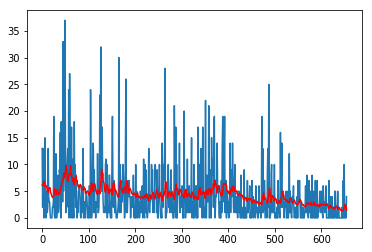

In [28]:

series = get_dataset()
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in tqdm(range(len(test))):
	model = sm.tsa.statespace.SARIMAX(history, order=(5,0,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = math.sqrt(mean_squared_error(test, predictions))
print('Test MSE: %.3f' % error)

## Plotting Predictions

1930    1.818470
1931    1.819585
1932    1.820082
1933    1.812519
1934    1.811864
1935    1.810511
1936    1.809124
1937    1.807569
1938    1.806372
1939    1.805134
1940    1.803907
1941    1.802687
1942    1.801487
1943    1.800287
1944    1.799089
1945    1.797894
1946    1.796701
1947    1.795508
1948    1.794317
1949    1.793127
1950    1.791937
dtype: float64


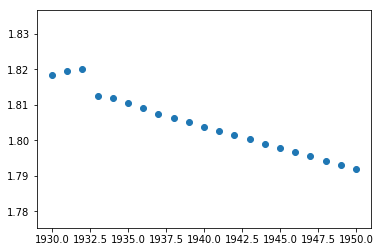

In [31]:
from statsmodels.tsa.arima_model import ARIMAResults
import matplotlib.pyplot as plt

model = ARIMAResults.load('arima_nowcasting.pkl')
# from pandas import datetime
# # start_index = datetime(1990, 12, 25)
# # end_index = datetime(1990, 12, 26)

start_index = 1930
end_index   = 1950
forecast = model.predict(start=start_index, end=end_index)
print(forecast)
plt.scatter(forecast.index.tolist(), forecast.values);